Processing of CART single cell samples.  6 scRNA-seq samples obtained from mice spleen. Samples comprise 3 mice with CART19 cell treatment and 3 mice with CART19 plus radiation treatment. In this study, GFP/Luciferase transduced mouse-derived diffuse large B cell lymphoma (DLBCL) cells were transplanted to BALB/c mice and treated with either only CART19 cells or CART19 plus radiation with the goal of studying how radiation may interfere in the efficacy of CART19 cells in DLBCL

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
#import scvi
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy.external as sce
import warnings
import torch
from rich import print
import anndata as ad


In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
#load data through a function to create a unique object for all the samples
def load_data(mouse_name, var_names='gene_symbols', cache=True):
    directory = f'/SSD/maa7095/scRNAseq/Guzman_CART/Cellranger_out/{mouse_name}/outs/filtered_feature_bc_matrix'
    adata = sc.read_10x_mtx(directory, var_names=var_names, cache=cache)
    adata.obs['Sample'] = mouse_name    
    #filter minimum numer of cells with really low cells.
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    return adata

In [4]:
mouse_names = ["out_Mouse_11", "out_Mouse_13", "out_Mouse_23", "out_Mouse_4", "out_Mouse_5", "out_Mouse_8"]

# Dictionary to store Anndata objects for each sample
all_data = {}

# Load data for each sample and store in the dictionary
for mouse_name in mouse_names:
    all_data[mouse_name] = load_data(mouse_name)
    print(f"Loaded data for {mouse_name}")

... writing an h5ad cache file to speedup reading next time
filtered out 131 cells that have less than 200 genes expressed
filtered out 12332 genes that are detected in less than 3 cells


Loaded data for out_Mouse_11

... writing an h5ad cache file to speedup reading next time
filtered out 65 cells that have less than 200 genes expressed
filtered out 13096 genes that are detected in less than 3 cells


Loaded data for out_Mouse_13

... writing an h5ad cache file to speedup reading next time
filtered out 31 cells that have less than 200 genes expressed
filtered out 12911 genes that are detected in less than 3 cells


Loaded data for out_Mouse_23

... writing an h5ad cache file to speedup reading next time
filtered out 92 cells that have less than 200 genes expressed
filtered out 13247 genes that are detected in less than 3 cells


Loaded data for out_Mouse_4

... writing an h5ad cache file to speedup reading next time
filtered out 206 cells that have less than 200 genes expressed
filtered out 12639 genes that are detected in less than 3 cells


Loaded data for out_Mouse_5

... writing an h5ad cache file to speedup reading next time
filtered out 201 cells that have less than 200 genes expressed
filtered out 12322 genes that are detected in less than 3 cells


Loaded data for out_Mouse_8

In [7]:
def plot_qc(all_data,obs_column, QC_feature):
   # Extract the number of genes per cell for each sample
    genes_per_cell_data = {
    mouse_name: adata.obs[obs_column]
        for mouse_name, adata in all_data.items()
    }
    data_for_plot = []
    for mouse_name, genes_per_cell in genes_per_cell_data.items():
        data_for_plot.extend([(mouse_name, num_genes) for num_genes in genes_per_cell])

    # Create a dataframe
    df = pd.DataFrame(data_for_plot, columns=['Sample',QC_feature])

    # add information of the condition of each mouse sample. So to merged_data.obs add a new column that will display cart or cart+radiation
    df["Condition"] = "CART"
    # Define conditions for specific samples
    conditions = {
        "out_Mouse_5": "CART_RAD",
        "out_Mouse_11": "CART_RAD",
        "out_Mouse_13": "CART_RAD",
    }

    # Update 'Condition' column based on conditions
    for sample, condition in conditions.items():
        df['Condition'] = np.where(df['Sample'] == sample, condition, df['Condition'])
    sample_order = ["out_Mouse_23",'out_Mouse_4','out_Mouse_8','out_Mouse_11','out_Mouse_13','out_Mouse_5']
    # Plot the violin plot
    plt.figure(figsize=(10, 6))
    vio_genes=sns.violinplot(x='Sample', y=QC_feature, data=df, hue='Condition', palette='Set1', order=sample_order)
    vio_genes.set_xticklabels(vio_genes.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Violin Plot of {QC_feature} for Each Sample')
    plt.show() 
    
            

/tmp/ipykernel_1558252/160155641.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  vio_genes.set_xticklabels(vio_genes.get_xticklabels(), rotation=45, ha='right')


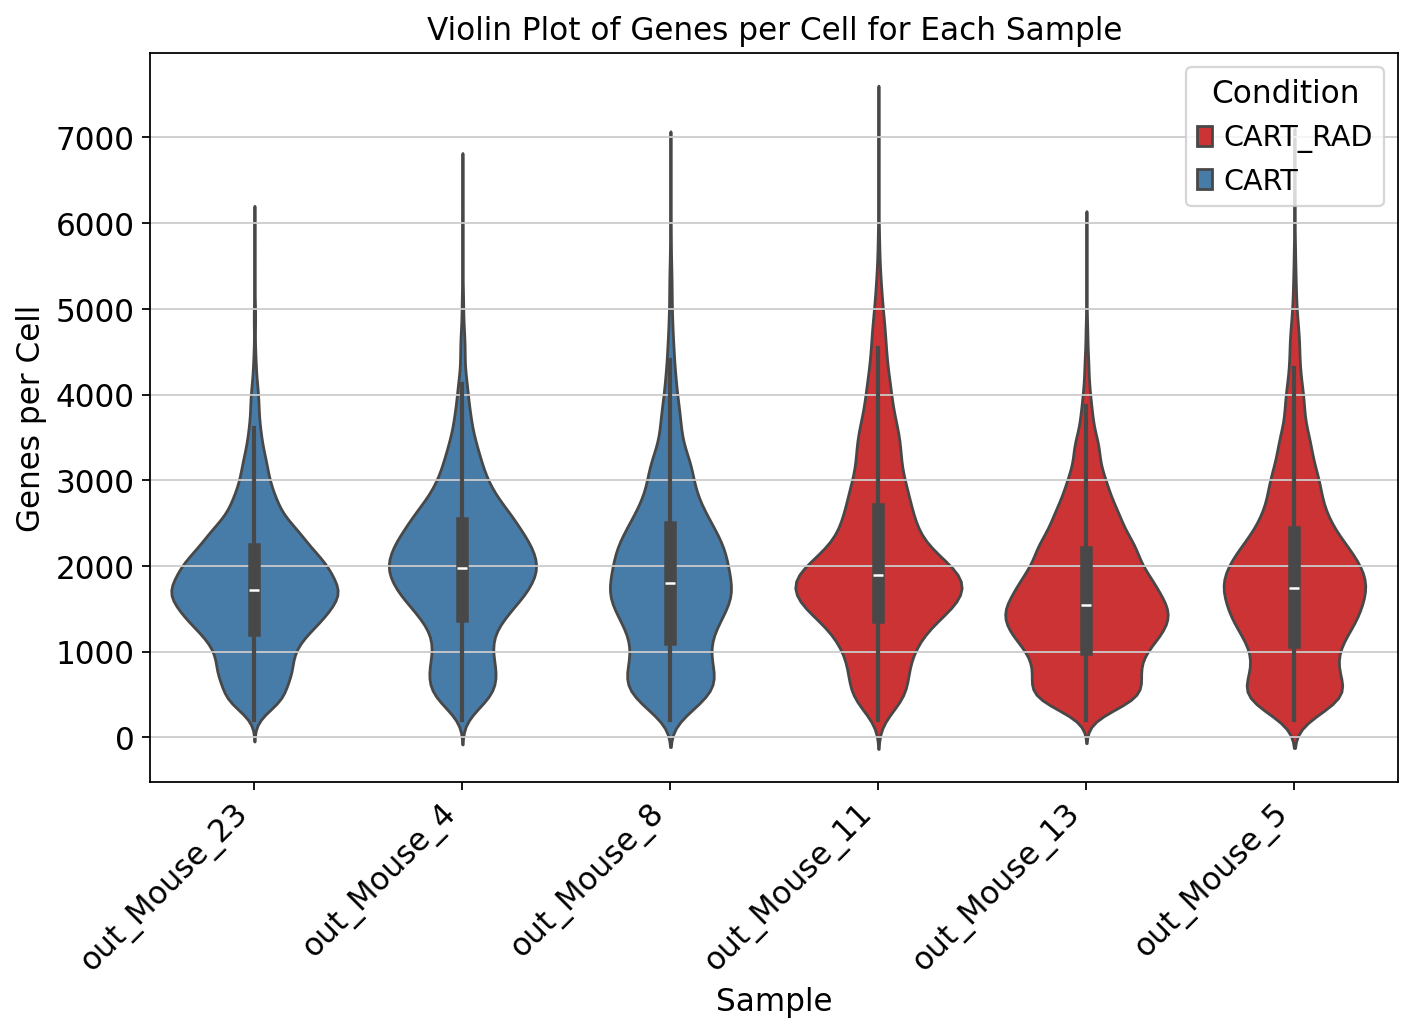

In [8]:
plot_qc(all_data,'n_genes_by_counts', 'Genes per Cell')

/tmp/ipykernel_1558252/160155641.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  vio_genes.set_xticklabels(vio_genes.get_xticklabels(), rotation=45, ha='right')


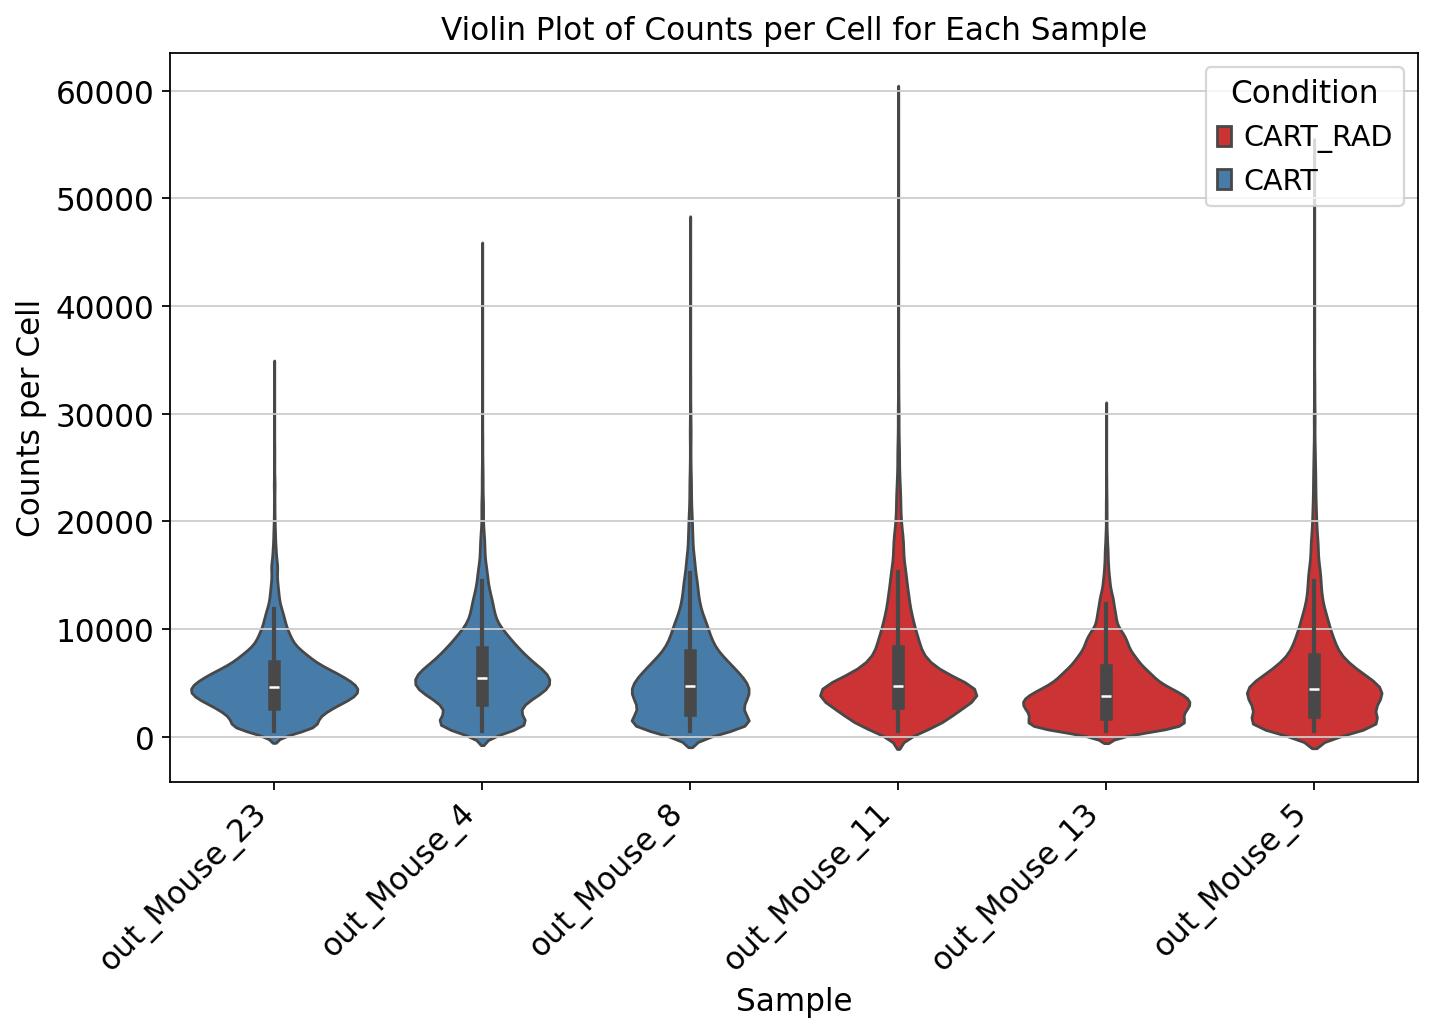

In [9]:
plot_qc(all_data,'total_counts', 'Counts per Cell')

/tmp/ipykernel_1558252/160155641.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  vio_genes.set_xticklabels(vio_genes.get_xticklabels(), rotation=45, ha='right')


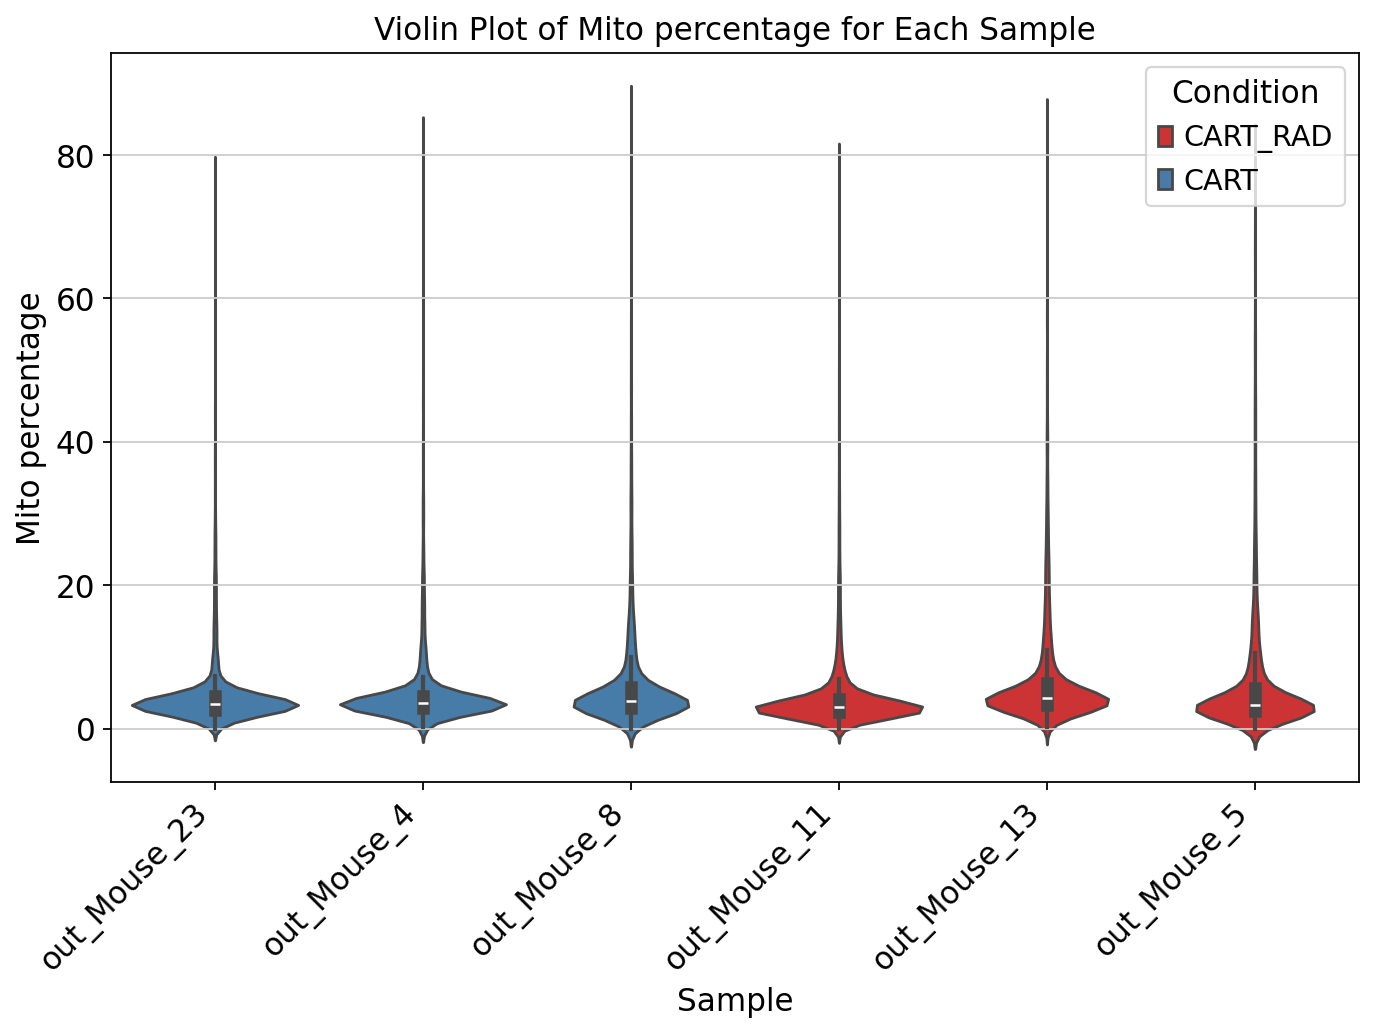

In [10]:
plot_qc(all_data,'pct_counts_mt', 'Mito percentage')

In [11]:
#create function to remove low quality cells. 
def filter_cells(adata_object):
    adata_object = adata_object[adata_object.obs['n_genes_by_counts'] > 50,:]
    adata_object = adata_object[adata_object.obs['total_counts'] < 30000, :]
    adata_object = adata_object[adata_object.obs['total_counts'] > 50, :]
    adata_object = adata_object[adata_object.obs.pct_counts_mt < 8, :]
    return adata_object
    

In [12]:
filtered_data = {}
for mouse_name, adata in all_data.items():
    filtered_data[mouse_name] = filter_cells(adata)

/tmp/ipykernel_1558252/160155641.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  vio_genes.set_xticklabels(vio_genes.get_xticklabels(), rotation=45, ha='right')


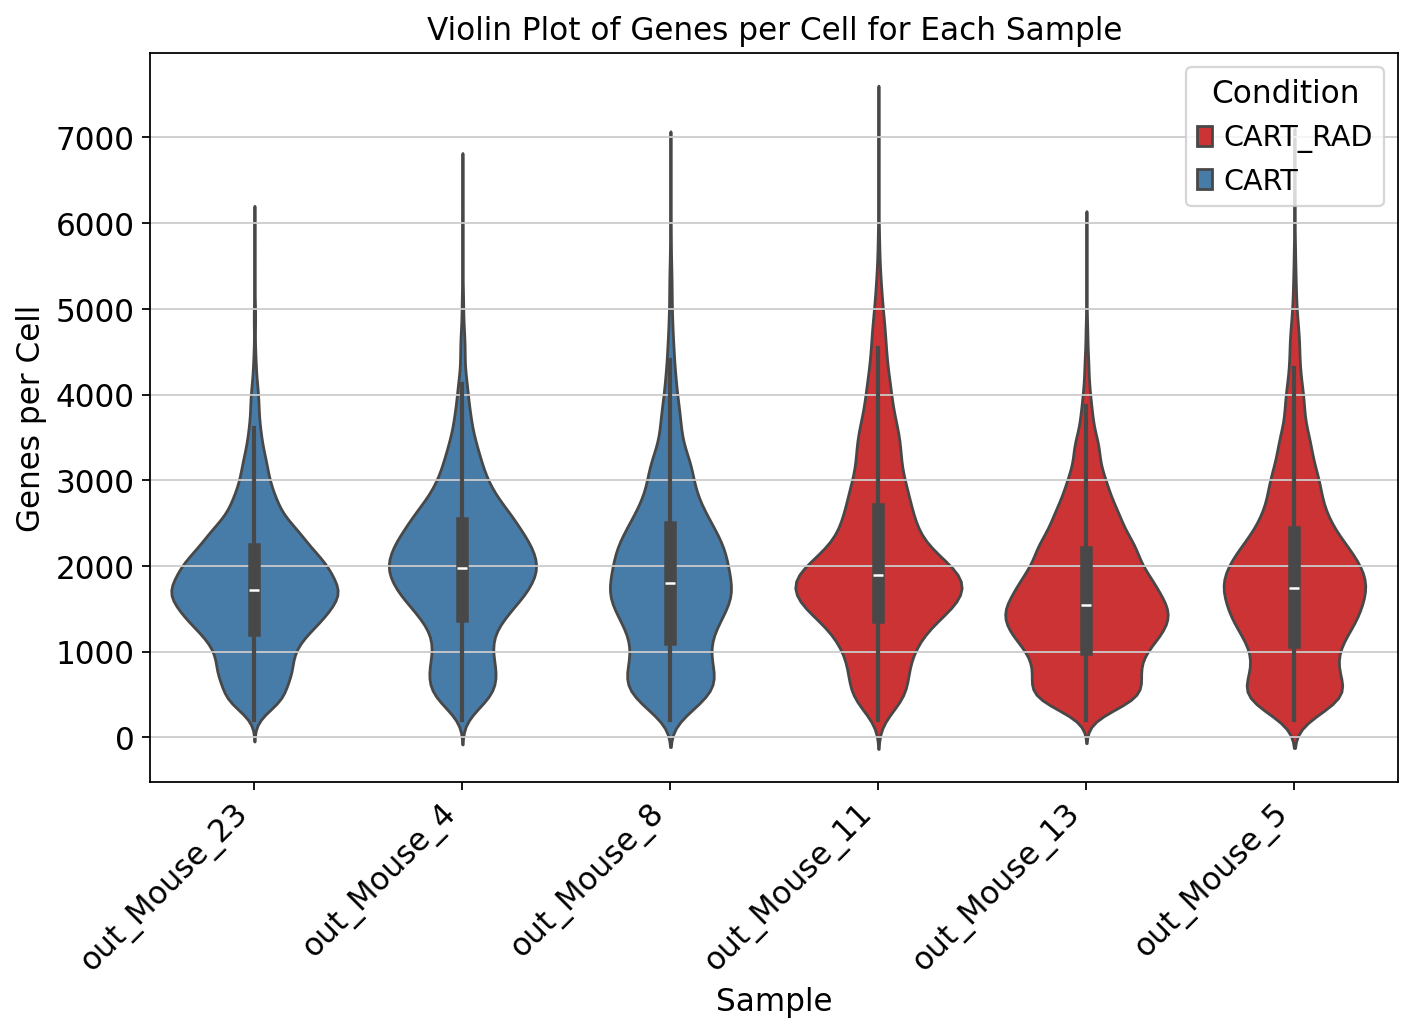

In [14]:
plot_qc(all_data,'n_genes_by_counts', 'Genes per Cell')

/tmp/ipykernel_1558252/160155641.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  vio_genes.set_xticklabels(vio_genes.get_xticklabels(), rotation=45, ha='right')


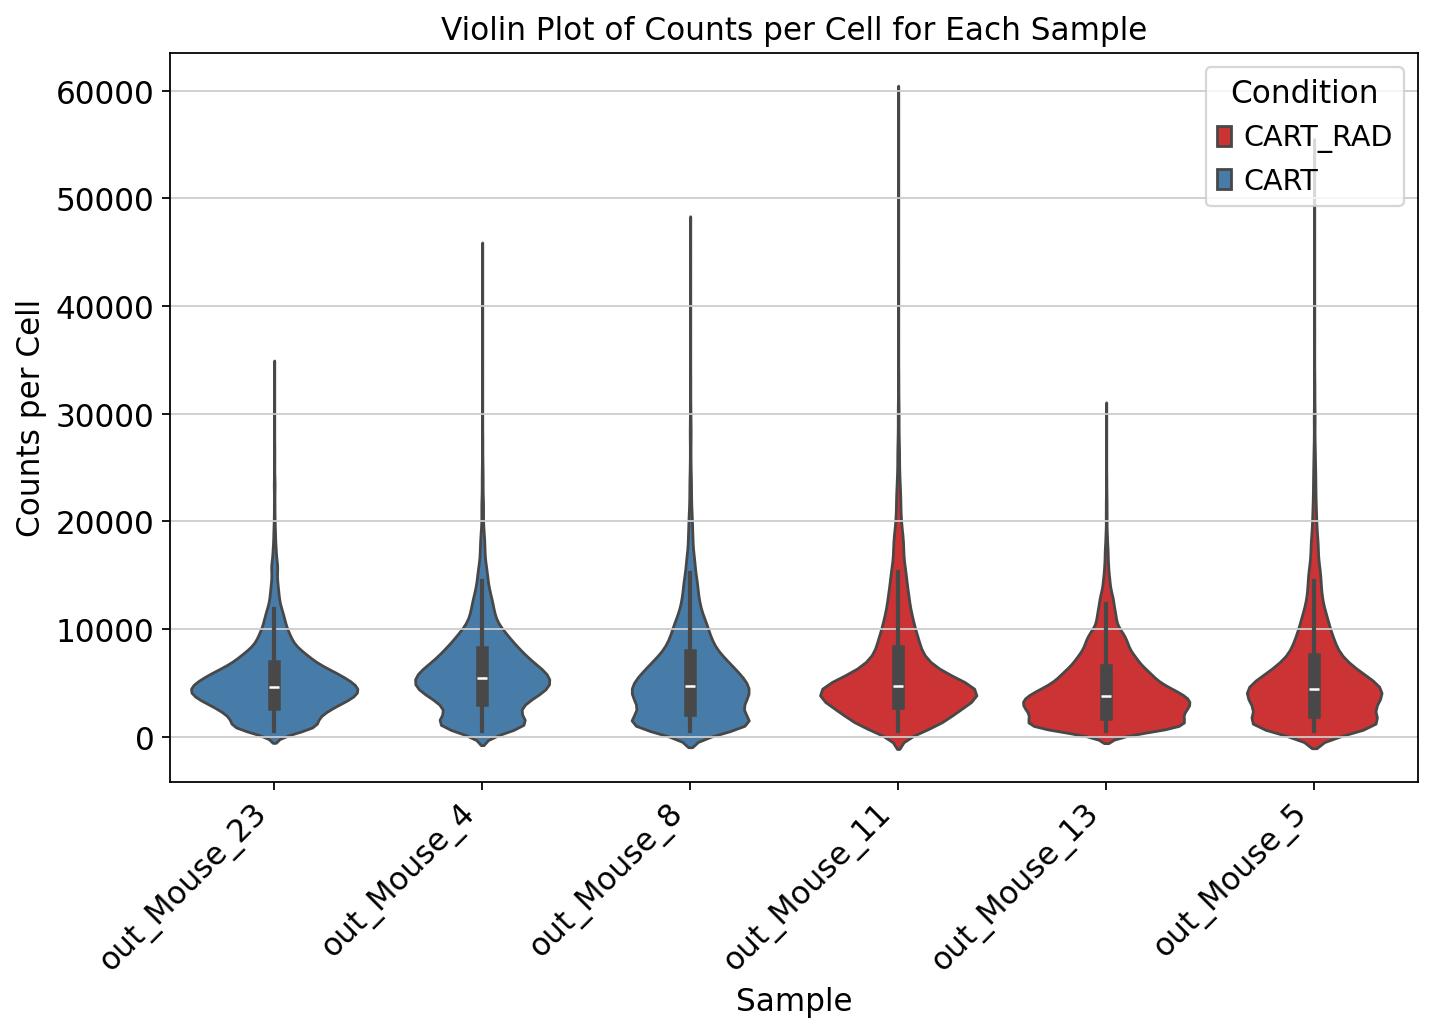

In [15]:
plot_qc(all_data,'total_counts', 'Counts per Cell')

/tmp/ipykernel_1558252/160155641.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  vio_genes.set_xticklabels(vio_genes.get_xticklabels(), rotation=45, ha='right')


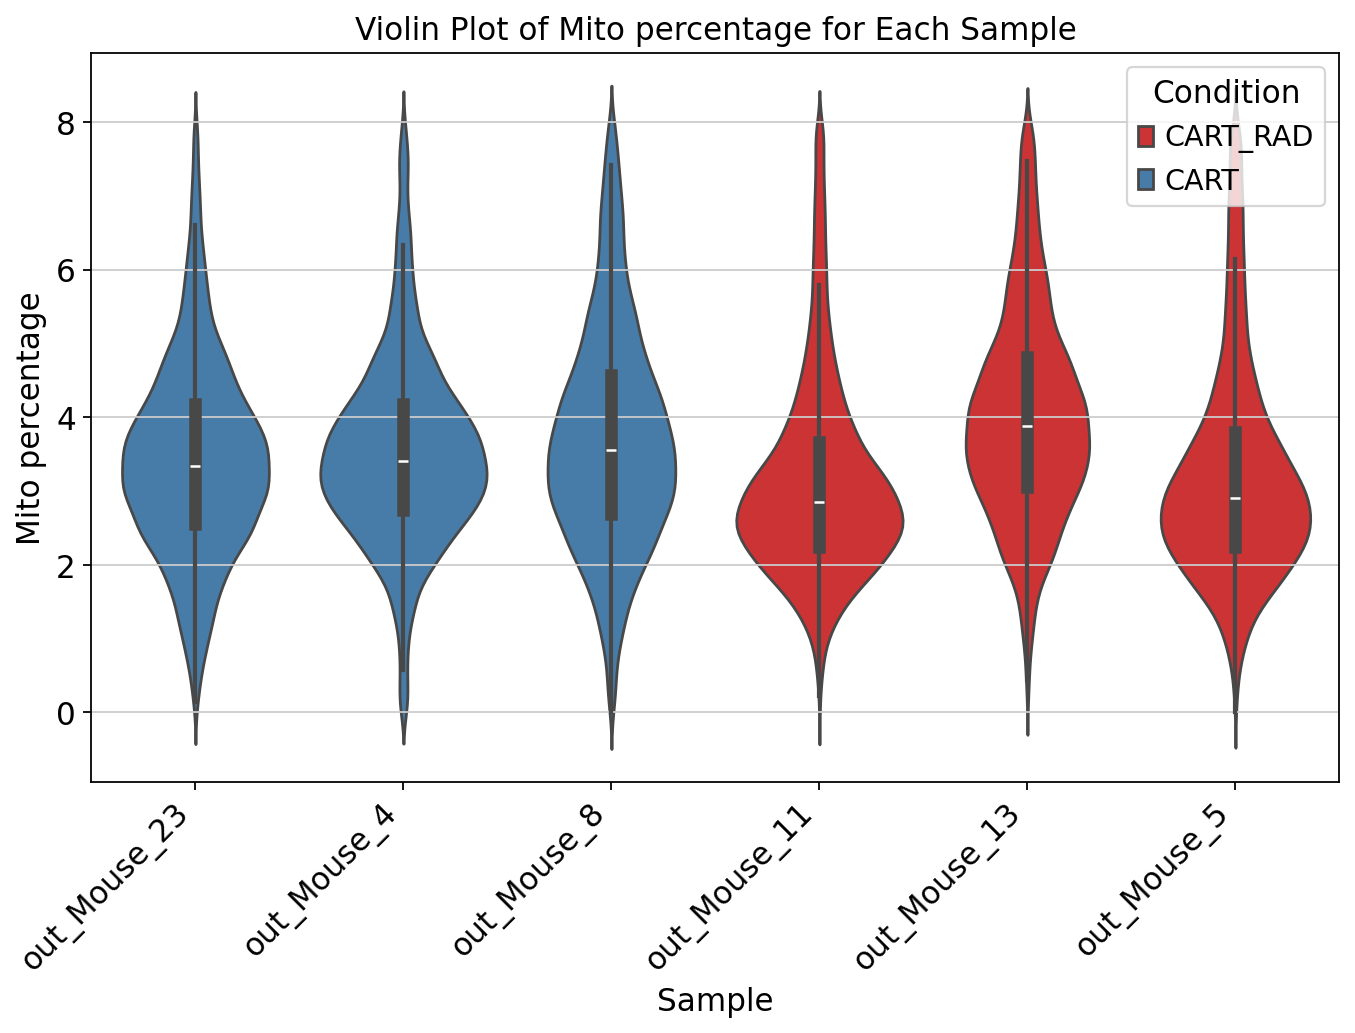

In [16]:
plot_qc(filtered_data,'pct_counts_mt', 'Mito percentage')

Single-Cell Remover of Doublets (Scrublet): a framework for predicting the impact of multiplets in a given analysis and identifying problematic multiplets. Scrublet avoids the need for expert knowledge or cell clustering by simulating multiplets from the data and building a nearest neighbor classifier. 

In [17]:
def remove_doublets(adata):
    sce.pp.scrublet(adata)
    adata.obs['predicted_doublet'].value_counts()
    adata = adata[~adata.obs['predicted_doublet'], :]
    adata.layers['counts'] = adata.X.copy()
    return adata

In [18]:
for mouse_name, adata in filtered_data.items():
    filtered_data[mouse_name] = remove_doublets(adata)

Running Scrublet
filtered out 187 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.9%
    Scrublet finished (0:00:08)


/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/external/pp/_scrublet.py:267: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = scrubbed['obs']['doublet_score']
/tmp/ipykernel_1558252/1429128393.py:6: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy()


Running Scrublet
filtered out 328 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 2.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.6%
    Scrublet finished (0:00:07)


/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/external/pp/_scrublet.py:267: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = scrubbed['obs']['doublet_score']
/tmp/ipykernel_1558252/1429128393.py:6: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy()


Running Scrublet
filtered out 139 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.23
Detected doublet rate = 3.1%
Estimated detectable doublet fraction = 39.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.9%
    Scrublet finished (0:00:07)


/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/external/pp/_scrublet.py:267: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = scrubbed['obs']['doublet_score']
/tmp/ipykernel_1558252/1429128393.py:6: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy()


Running Scrublet
filtered out 144 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.9%
    Scrublet finished (0:00:07)


/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/external/pp/_scrublet.py:267: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = scrubbed['obs']['doublet_score']
/tmp/ipykernel_1558252/1429128393.py:6: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy()


Running Scrublet
filtered out 306 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 3.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.4%
    Scrublet finished (0:00:07)


/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/external/pp/_scrublet.py:267: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = scrubbed['obs']['doublet_score']
/tmp/ipykernel_1558252/1429128393.py:6: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy()


Running Scrublet
filtered out 264 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.21
Detected doublet rate = 3.5%
Estimated detectable doublet fraction = 37.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 9.3%
    Scrublet finished (0:00:07)


/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/external/pp/_scrublet.py:267: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = scrubbed['obs']['doublet_score']
/tmp/ipykernel_1558252/1429128393.py:6: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy()


In [24]:
# Concatenate the datasets into a single Anndata object.
#to keep original indexes. index_unique=None
merged_data = sc.AnnData.concatenate(*filtered_data.values(), batch_key='batch')
merged_data.layers['counts'] = merged_data.X.copy() # move count data into a layer

In [25]:
sc.pp.normalize_total(merged_data)
sc.pp.log1p(merged_data) 
sc.pp.highly_variable_genes(merged_data, min_mean=0.0125, max_mean=3, min_disp=0.5)
merged_data.raw = merged_data  # keep full dimension safe. save normalized and log transformed values to .raw


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [26]:
merged_data.obs["Condition"] = "CART"
# Define conditions for specific samples
conditions = {
    "out_Mouse_5": "CART_RAD",
    "out_Mouse_11": "CART_RAD",
    "out_Mouse_13": "CART_RAD",
}

# Update 'Condition' column based on conditions
for sample, condition in conditions.items():
    merged_data.obs['Condition'] = np.where(merged_data.obs['Sample'] == sample, condition, merged_data.obs['Condition'])

In [66]:
# save object
filename_raw = 'raw_concat_guzman.h5ad'
#merged_data.write(filename_raw)

In [67]:
#load harmony integrated data.
filename_raw = 'raw_concat_guzman.h5ad'

# Read the HDF5 file into a DataFrame
merged_data = ad.read_h5ad(filename_raw)

In [29]:
#check embedding of cells without batch corrections
merged_data_nothing = merged_data.copy()
sc.pp.scale(merged_data_nothing)
sc.tl.pca(merged_data_nothing)
sc.pp.neighbors(merged_data_nothing)
sc.tl.louvain(merged_data_nothing)
sc.tl.umap(merged_data_nothing)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


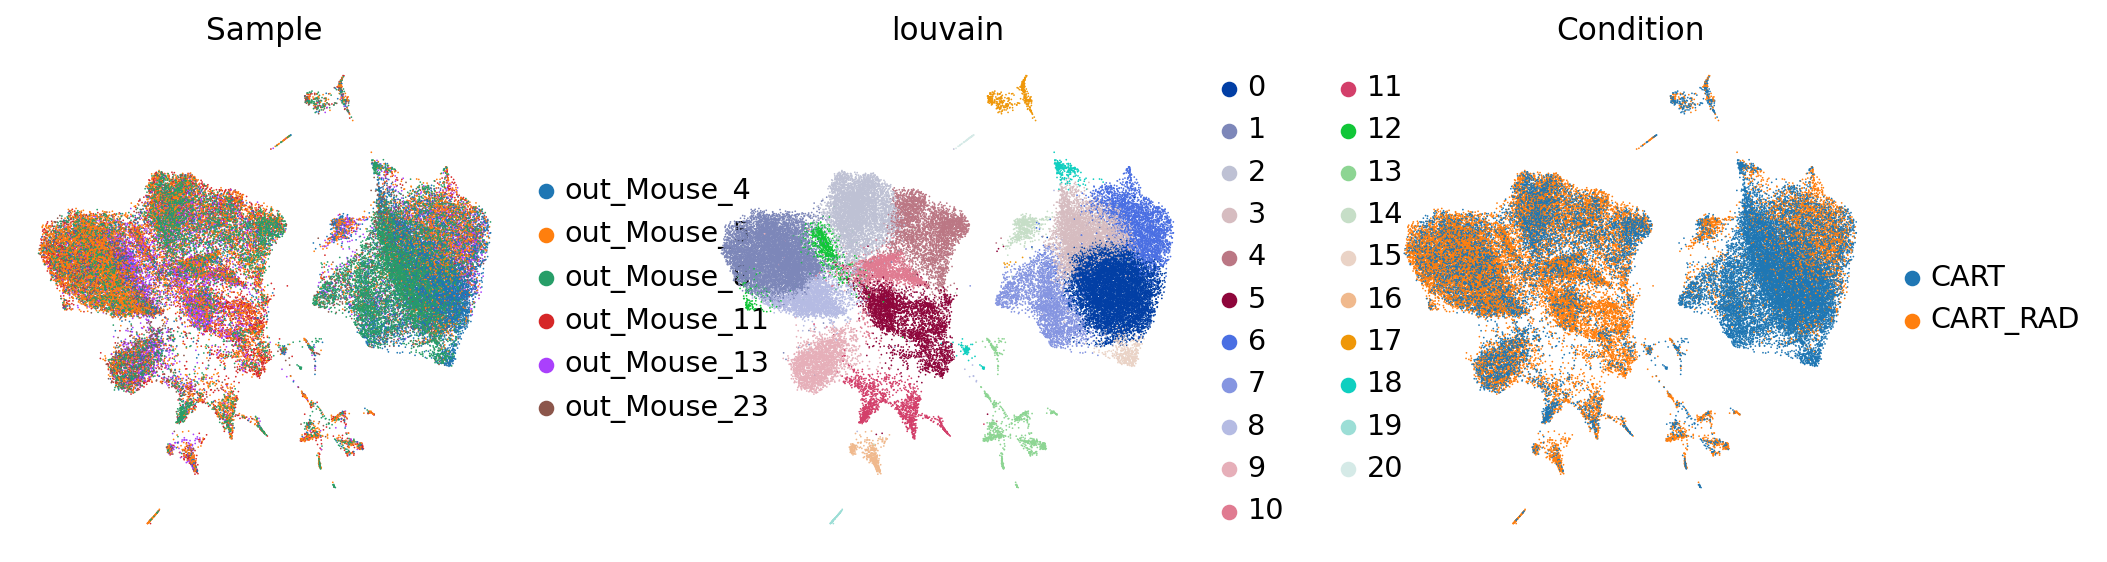

In [41]:
sc.pl.umap(
    merged_data_nothing,
    color=["Sample", "louvain", "Condition"],
    frameon=False,
    wspace=0.25,
    return_fig=True,
)

Harmony begins with a low-dimensional embedding of cells, such as principal components analysis (PCA), (Supplementary Note 1 and Methods). Using this embedding, Harmony first groups cells into multi-dataset clusters (Fig. 1a). We use soft clustering to assign cells to potentially multiple clusters, to account for smooth transitions between cell states. These clusters serve as surrogate variables, rather than to identify discrete cell types. We developed a new soft k-means clustering algorithm that favors clusters with cells from multiple datasets (Methods). Clusters disproportionately containing cells from a small subset of datasets are penalized by an information theoretic metric. Harmony allows for multiple different penalties to accommodate multiple technical or biological factors, such as different batches and tissue sources. Soft clustering preserves discrete and continuous topologies while avoiding local minima that might result from maximizing representation too quickly across multiple datasets. After clustering, each dataset has cluster-specific centroids (Fig. 1b) that are used to compute cluster-specific linear correction factors (Fig. 1c). Since clusters correspond to cell types and states, cluster-specific correction factors correspond to individual cell-type and cell-state specific correction factors. In this way, Harmony learns a simple linear adjustment function that is sensitive to intrinsic cellular phenotypes. Finally, each cell is assigned a cluster-weighted average of these terms and corrected by its cell-specific linear factor (Fig. 1d). Since each cell may be in multiple clusters, each cell has a potentially unique correction factor. Harmony iterates these four steps until cell cluster assignments are stable.

PCA embeds cells into a space with reduced dimensionality. Harmony accepts the cell coordinates in this reduced space and runs an iterative algorithm to adjust for dataset specific effects. a, Harmony uses fuzzy clustering to assign each cell to multiple clusters, while a penalty term ensures that the diversity of datasets within each cluster is maximized. b, Harmony calculates a global centroid for each cluster, as well as dataset-specific centroids for each cluster. c, Within each cluster, Harmony calculates a correction factor for each dataset based on the centroids. d, Finally, Harmony corrects each cell with a cell-specific factor: a linear combination of dataset correction factors weighted by the cell’s soft cluster assignments made in step a. Harmony repeats steps a to d until convergence. The dependence between cluster assignment and dataset diminishes with each round. Datasets are represented with colors, cell types with different shapes.

In [32]:
merged_data_harmony = merged_data.copy()

In [33]:
sc.pp.scale(merged_data_harmony)
sc.tl.pca(merged_data_harmony)
sc.external.pp.harmony_integrate(merged_data_harmony, key="batch")



... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


2024-04-11 16:30:45,149 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-11 16:30:55,497 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-04-11 16:30:55,621 - harmonypy - INFO - Iteration 1 of 10
2024-04-11 16:31:02,282 - harmonypy - INFO - Iteration 2 of 10
2024-04-11 16:31:08,931 - harmonypy - INFO - Iteration 3 of 10
2024-04-11 16:31:15,084 - harmonypy - INFO - Converged after 3 iterations


In [34]:
sc.pp.neighbors(merged_data_harmony, use_rep="X_pca_harmony", n_neighbors=30)
sc.tl.louvain(merged_data_harmony)
sc.tl.umap(merged_data_harmony)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 19 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:26)


In [37]:
merged_data_harmony

AnnData object with n_obs × n_vars = 49968 × 17278
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'batch', 'Condition', 'louvain'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'n_cells-3', 'n_cells_by_counts-3', 'mean_counts-3', 'pct_dropout_by_counts-3', 'total_counts-3', 'n_cells-4', 'n_cells_by_counts-4', 'mean_counts-4', 'pct_dropout_by_counts-4', 'total_counts-4', 'n_cells-5', 'n_cells_by_counts-5', 'mean_counts-5', 'pct_dropout_by_counts-5', 'total_counts-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'umap', 'Sa

/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


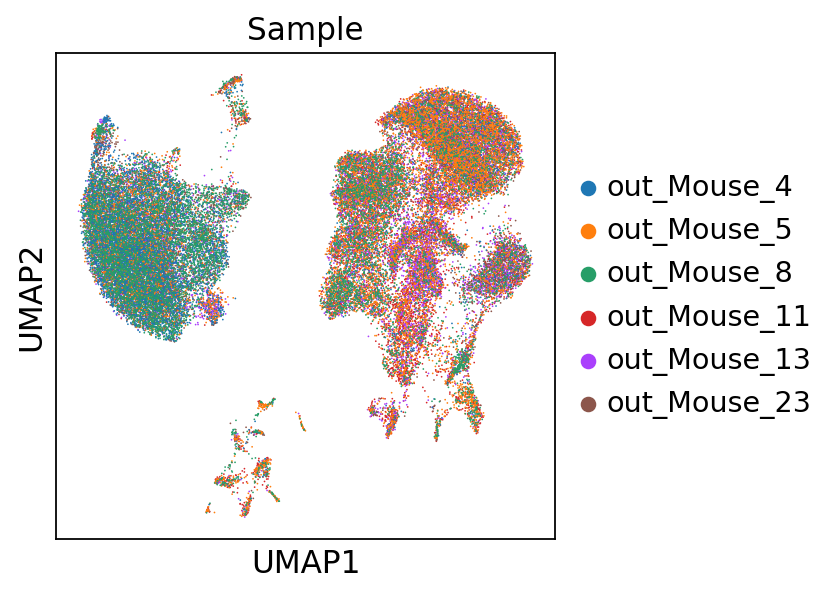

In [46]:
sc.pl.umap(
    merged_data_harmony,
    color=["Sample"],
)

/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


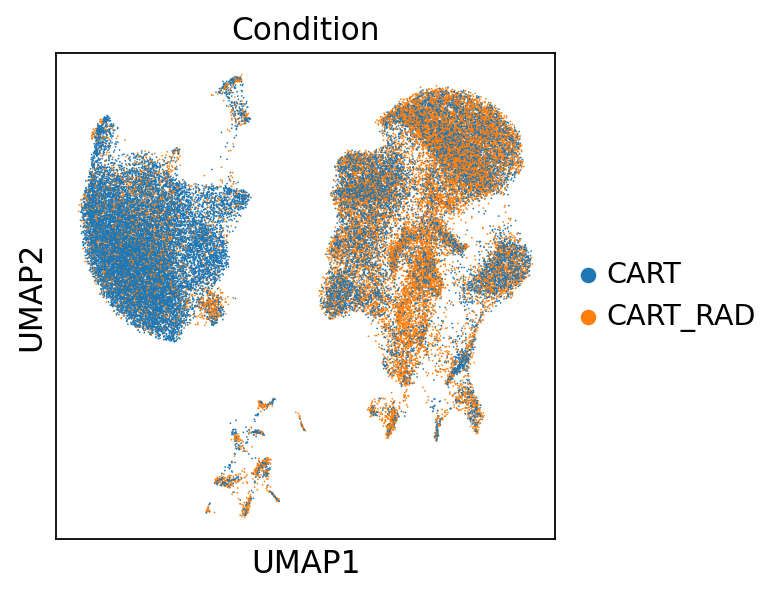

In [47]:
sc.pl.umap(
    merged_data_harmony,
    color=["Condition"],
)

/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


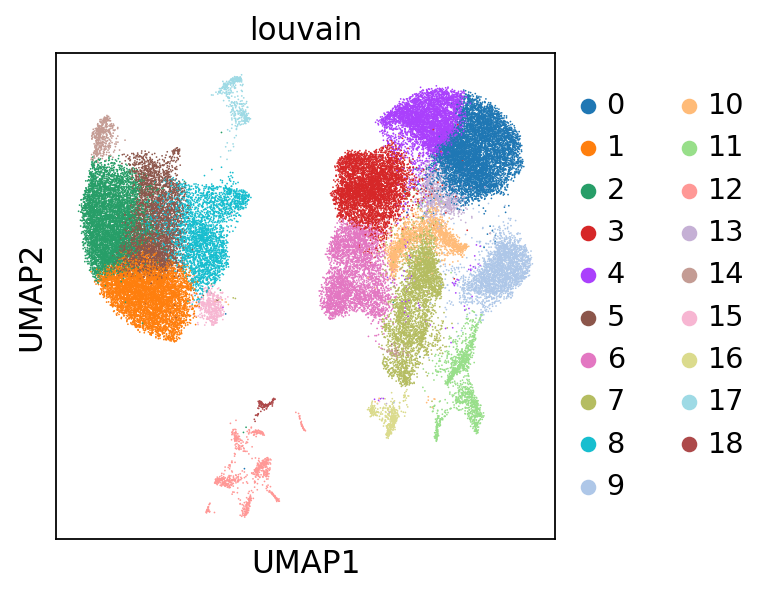

In [48]:
sc.pl.umap(
    merged_data_harmony,
    color=["louvain"],
)


/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


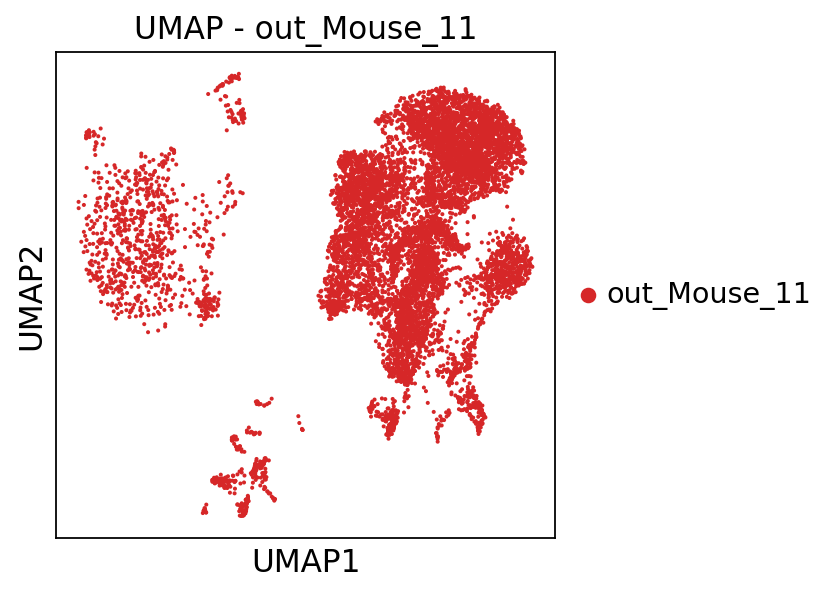

/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


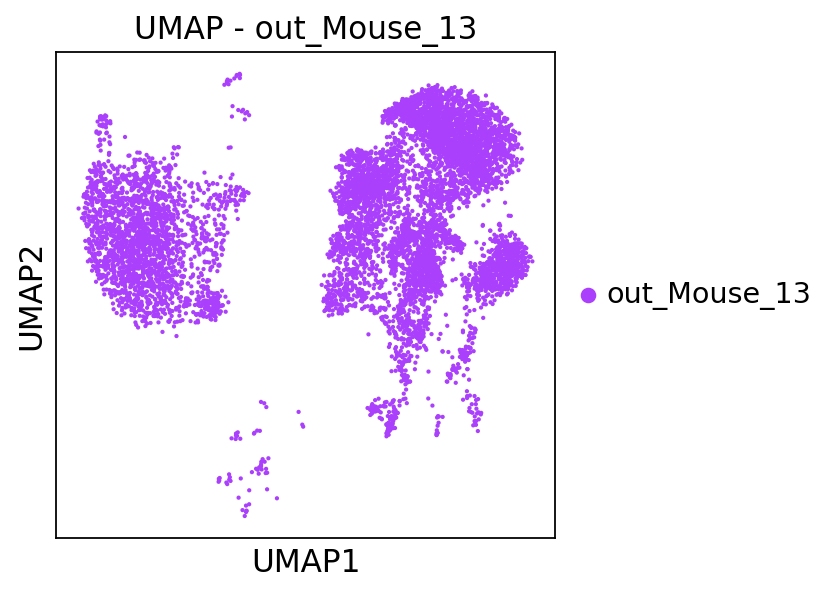

/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


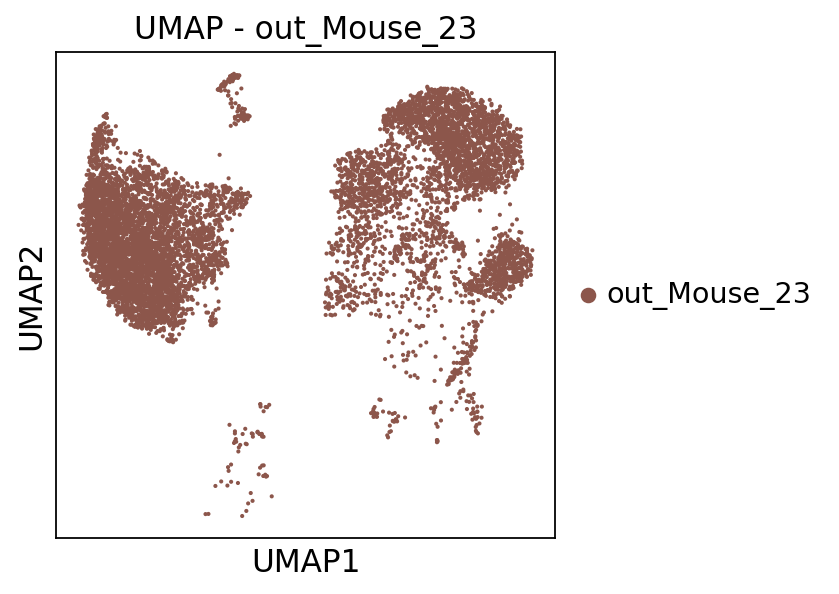

/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


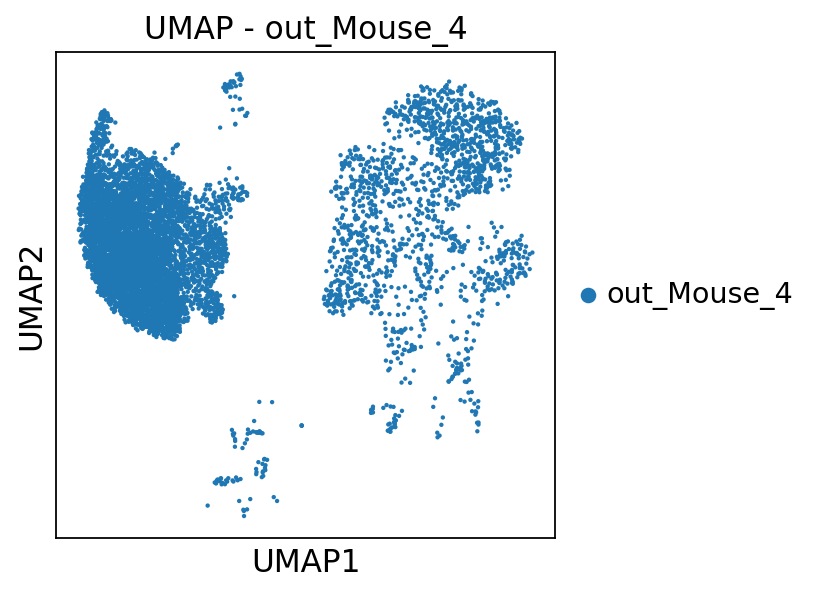

/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


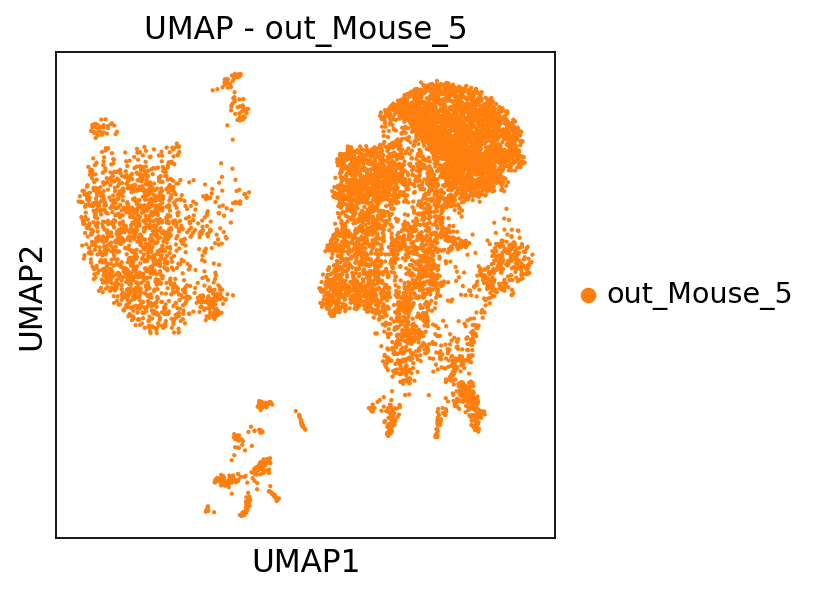

/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


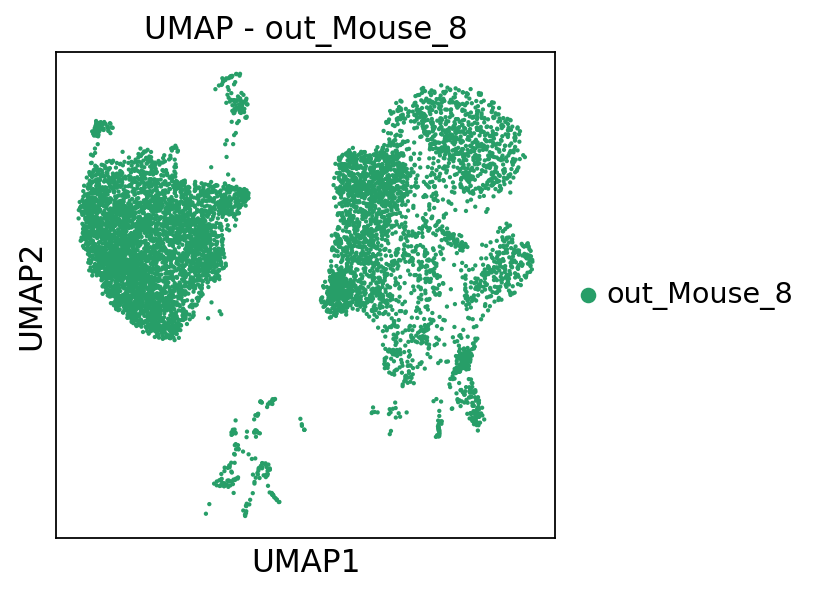

In [49]:
for sample in merged_data_harmony.obs['Sample'].unique():
    # Subset the data for the current sample
    subset_data = merged_data_harmony[merged_data_harmony.obs['Sample'] == sample, :]
    # Plot UMAP with color based on batch
    sc.pl.umap(subset_data, color='Sample', title=f'UMAP - {sample}')
    

In [12]:
for condition in merged_data_harmony.obs['Condition'].unique():
    # Subset the data for the current sample
    subset_data = merged_data_harmony[merged_data_harmony.obs['Condition'] == condition, :]
    # Plot UMAP with color based on batch
    sc.pl.umap(subset_data, 
               color='Condition', title=f'{condition}', return_fig=True)
    fig = plt.gcf()
    ax = plt.gca()

    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Optionally, you can save or display the modified figure
    fig.savefig(f' {condition} _umap.png')
    plt.close(fig) 

/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(merged_data_harmony, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(merged_data_harmony, n_genes=25, sharey=False)

ranking genes


In [52]:
integrated_harmony=merged_data_harmony

In [ ]:
#save harmony object.
integrated_harmony = 'integrated_harmony_guzman.h5ad'
#merged_data_harmony.write(integrated_harmony)

In [4]:
#load harmony integrated data.
integrated_data_path = '../integrated_harmony_guzman.h5ad'

# Read the HDF5 file into a DataFrame
integrated_harmony = ad.read_h5ad(integrated_data_path)

In [11]:
for condition in integrated_harmony.obs['Condition'].unique():
    # Subset the data for the current sample
    subset_data = integrated_harmony[integrated_harmony.obs['Condition'] == condition, :]
    
    # Plot UMAP with color based on the condition
    fig = sc.pl.umap(
        subset_data, 
        color='Condition', 
        title=f'{condition}', 
        return_fig=True,  # Capture the returned figure
        frameon=None, size=8
    )

    # Access the axes
    ax = fig.axes[0]

    # Remove spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Save the figure for the current condition
    fig.savefig(f'{condition}_umap.pdf', bbox_inches='tight', format='pdf')

    # Close the figure to free memory
    plt.close(fig)

In [5]:
#save results of the top markers.
df_markers_harmony = sc.get.rank_genes_groups_df(adata=integrated_harmony, group=None)

In [ ]:
# Assuming 'df_markers_harmony' is your DataFrame
df_markers_harmony.to_csv('integration_markers_harmony.csv', index=False)

In [5]:
top_markers=pd.DataFrame(integrated_harmony.uns['rank_genes_groups']['names']).head(5)
# Initialize an empty dictionary to store the marker genes for each cluster
marker = {}

# Iterate over the columns of the DataFrame
for cluster in top_markers.columns:
    # Convert the cluster to a string
    cluster_str = str(cluster)
    # Extract the genes for the current cluster
    genes = top_markers[cluster].dropna().tolist()
    # Add the genes for the current cluster to the dictionary
    marker[cluster_str] = genes

marker

{'0': ['Lef1', 'Arhgap15', 'Satb1', 'Itk', 'Skap1'],
 '1': ['Bank1', 'Ebf1', 'Pax5', 'Gm31243', 'Mef2c'],
 '2': ['Cd74', 'Cd79a', 'H2-Aa', 'Igkc', 'Cd79b'],
 '3': ['Ikzf2', 'Il2ra', 'Ctla4', 'Smc4', 'Ift80'],
 '4': ['Rps16', 'Tpt1', 'Rplp1', 'Rps10', 'Rpl19'],
 '5': ['H2-Ab1', 'Cd83', 'H2-Eb1', 'Swap70', 'Mef2c'],
 '6': ['Ikzf2', 'Ctla4', 'Tox', 'Atxn1', 'Rabgap1l'],
 '7': ['Lgals1', 'Ifi27l2a', 'S100a10', 'Actb', 'Coro1a'],
 '8': ['Ighm', 'Cacna1e', 'Plac8', 'Mzb1', 'Tcf4'],
 '9': ['Cd8b1', 'Nkg7', 'Cd8a', 'Sidt1', 'Slco3a1'],
 '10': ['Itgb1', 'Cd28', 'Atxn1', 'Themis', 'Slc9a9'],
 '11': ['Chn2', 'Cd7', 'Ccl5', 'Nkg7', 'AW112010'],
 '12': ['Cst3', 'Ftl1', 'Atox1', 'Tyrobp', 'Tmsb4x'],
 '13': ['Sidt1', 'Satb1', 'Gm2682', 'Arhgap15', 'Lef1'],
 '14': ['Rps8', 'Rpl13', 'Rps12', 'Rpl27a', 'Rpl11'],
 '15': ['Snx29', 'Pax5', 'Pkib', 'Mef2c', 'Swap70'],
 '16': ['Zbtb16', 'Id2', 'St6galnac3', 'Slc9a9', 'Rora'],
 '17': ['Jchain', 'Ighm', 'Txndc5', 'Igkc', 'Ly6c2'],
 '18': ['Hdc', 'Fcer1g', 'Gab

/home/maa7095/miniconda3/envs/sc_python/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


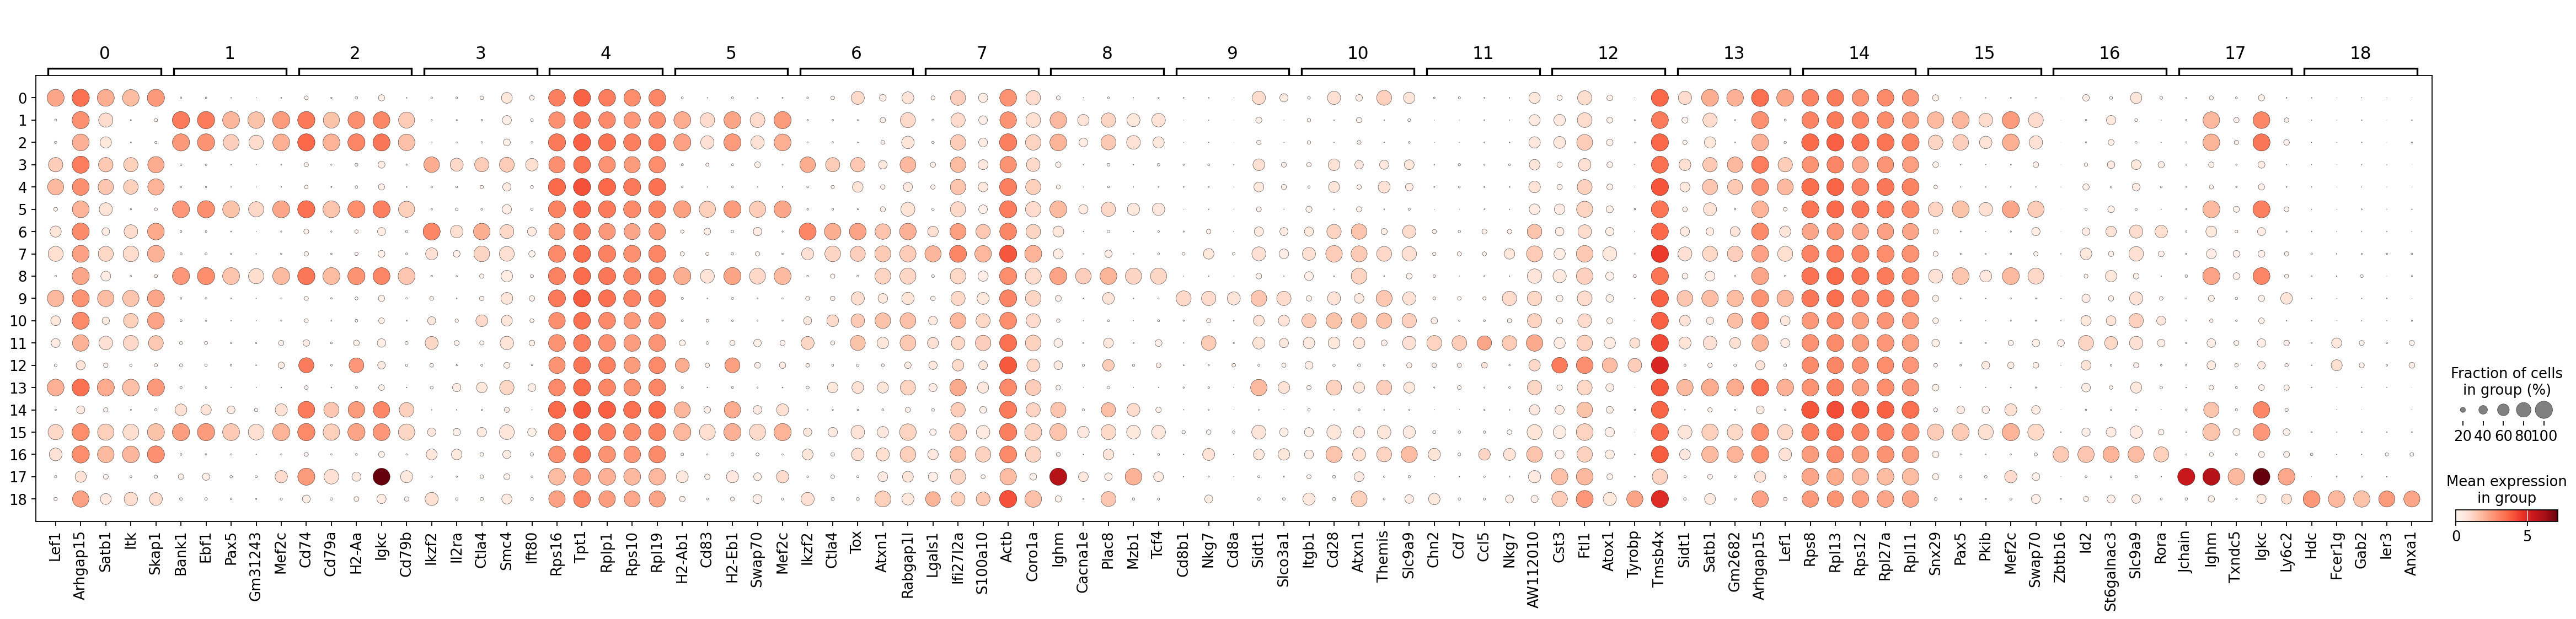

In [7]:
sc.pl.dotplot(integrated_harmony, marker, groupby='louvain')

In [3]:
#keep track of used version for all the packages
!pip freeze

absl-py @ file:///home/conda/feedstock_root/build_artifacts/absl-py_1705494584803/work
adjustText @ file:///home/conda/feedstock_root/build_artifacts/adjusttext_1705321634488/work
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1706292253763/work
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1695617111177/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1702909220329/work
argcomplete @ file:///home/conda/feedstock_root/build_artifacts/argcomplete_1706095296697/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1692818318753/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1695386546427/work
array_api_compat @ file:///home/conda/feedstock_root/build_artifacts/array-api-compat_1705865709207/work
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_1696128962909/work
arviz==0.17.0
assorthead==0.0.11
asttokens @ file:///home/conda/feeds

In [4]:
import pkg_resources

# Get a list of installed packages and their versions
installed_packages = [(pkg.key, pkg.version) for pkg in pkg_resources.working_set]

# Print the package names and versions
for package, version in installed_packages:
    print(f"{package}=={version}")


babel==2.14.0

biocframe==0.5.9

brotli==1.1.0

cython==3.0.8

delayedarray==0.5.0

genomicranges==0.4.12

iranges==0.2.3

jinja2==3.1.3

markdown==3.5.2

markupsafe==2.1.4

pycomplexheatmap==1.6.5

pyjwt==2.8.0

pyqt5==5.15.9

pyqt5-sip==12.12.2

pysocks==1.7.1

pywavelets==1.4.1

pyyaml==6.0.1

qtpy==2.4.1

send2trash==1.8.2

summarizedexperiment==0.4.3

absl-py==2.1.0

adjusttext==1.0.4

anndata==0.10.5.post1

annoy==1.17.2

anyio==4.2.0

argcomplete==3.2.2

argon2-cffi==23.1.0

argon2-cffi-bindings==21.2.0

array-api-compat==1.4.1

arrow==1.3.0

arviz==0.17.0

assorthead==0.0.11

asttokens==2.4.1

astunparse==1.6.3

async-lru==2.0.4

attrs==23.2.0

backoff==2.2.1

bbknn==1.6.0

beautifulsoup4==4.12.3

biocutils==0.1.5

bleach==6.1.0

blessed==1.19.1

boto3==1.34.32

botocore==1.34.32

cached-property==1.5.2

cachetools==5.3.2

certifi==2024.2.2

cffi==1.16.0

charset-normalizer==3.3.2

chex==0.1.85

click==8.1.7

cloudpickle==3.0.0

colorama==0.4.6

comm==0.2.1

contextlib2==21.6.0

contourpy==1.2.0

croniter==1.4.1

cycler==0.12.1

dateutils==0.6.12

debugpy==1.8.0

decorator==5.1.1

decoupler==1.5.0

deepdiff==6.7.1

defusedxml==0.7.1

dm-tree==0.1.8

docrep==0.3.2

entrypoints==0.4

et-xmlfile==1.1.0

etils==1.6.0

exceptiongroup==1.2.0

executing==2.0.1

fastapi==0.99.1

fastjsonschema==2.19.1

filelock==3.13.1

flatbuffers==23.5.26

flax==0.8.0

fonttools==4.47.2

fqdn==1.5.1

fsspec==2023.12.2

gast==0.5.4

get-annotations==0.1.2

gmpy2==2.1.2

google-auth==2.28.0

google-auth-oauthlib==1.2.0

google-pasta==0.2.0

grpcio==1.60.1

gtfparse==2.5.0

h11==0.14.0

h5netcdf==1.3.0

h5py==3.10.0

harmonypy==0.0.9

hdmedians==0.14.2

idna==3.6

igraph==0.11.3

imagecodecs==2024.1.1

imageio==2.33.1

importlib-metadata==7.0.1

importlib-resources==6.1.1

infercnvpy==0.4.4

inflect==7.0.0

inquirer==3.1.4

ipykernel==6.29.0

ipython==8.21.0

ipywidgets==8.1.1

isoduration==20.11.0

itsdangerous==2.1.2

jax==0.4.23

jaxlib==0.4.23.dev20240125

jedi==0.19.1

jmespath==1.0.1

joblib==1.3.2

json5==0.9.14

jsonpointer==2.4

jsonschema==4.21.1

jsonschema-specifications==2023.12.1

jupyter==1.0.0

jupyter-client==8.6.0

jupyter-console==6.6.3

jupyter-core==5.7.1

jupyter-events==0.9.0

jupyter-lsp==2.2.2

jupyter-server==2.12.5

jupyter-server-terminals==0.5.2

jupyterlab==4.0.12

jupyterlab-pygments==0.3.0

jupyterlab-server==2.25.2

jupyterlab-widgets==3.0.9

keras==2.15.0

kiwisolver==1.4.5

lazy-loader==0.3

leidenalg==0.10.2

libclang==16.0.6

lightning==2.0.9.post0

lightning-cloud==0.5.64

lightning-utilities==0.10.1

llvmlite==0.41.1

louvain==0.8.1

markdown-it-py==3.0.0

matplotlib==3.8.2

matplotlib-inline==0.1.6

mattress==0.1.6

mdurl==0.1.2

mistune==3.0.2

ml-collections==0.1.1

ml-dtypes==0.2.0

mpmath==1.3.0

msgpack==1.0.7

mudata==0.2.3

multipledispatch==0.6.0

munkres==1.1.4

natsort==8.4.0

nbclient==0.8.0

nbconvert==7.14.2

nbformat==5.9.2

ncls==0.0.68

nest-asyncio==1.6.0

networkx==3.2.1

notebook==7.0.7

notebook-shim==0.2.3

numba==0.58.1

numexpr==2.8.8

numpy==1.26.3

numpyro==0.13.2

oauthlib==3.2.2

omnipath==1.0.8

openpyxl==3.1.2

opt-einsum==3.3.0

optax==0.1.8

orbax-checkpoint==0.4.4

ordered-set==4.1.0

orjson==3.9.10

overrides==7.7.0

packaging==23.2

pandas==1.5.3

pandocfilters==1.5.0

parso==0.8.3

patsy==0.5.6

pexpect==4.9.0

pickleshare==0.7.5

pillow==10.2.0

pip==23.3.2

pkgutil-resolve-name==1.3.10

platformdirs==4.2.0

ply==3.11

polars==0.20.7

prometheus-client==0.19.0

prompt-toolkit==3.0.42

protobuf==4.25.1

psutil==5.9.8

ptyprocess==0.7.0

pure-eval==0.2.2

py-cpuinfo==9.0.0

pyarrow==14.0.2

pyasn1==0.5.1

pyasn1-modules==0.3.0

pycparser==2.21

pydantic==1.10.13

pydeseq2==0.4.5

pygments==2.17.2

pynndescent==0.5.11

pyparsing==3.1.1

pyreadr==0.5.0

pyro-api==0.1.2

pyro-ppl==1.8.6+4be5c2e

python-dateutil==2.8.2

python-editor==1.0.4

python-json-logger==2.0.7

python-multipart==0.0.6

pytoml==0.1.21

pytorch-lightning==2.1.3

pytz==2023.4

pyzmq==25.1.2

qtconsole==5.5.1

readchar==4.0.5.dev0

referencing==0.33.0

requests==2.31.0

requests-oauthlib==1.3.1

rfc3339-validator==0.1.4

rfc3986-validator==0.1.1

rich==13.7.0

rpds-py==0.17.1

rpy2==3.5.11

rsa==4.9

s3transfer==0.10.0

sccoda==0.1.9

scanpro==0.2

scanpy==1.9.8

scikit-bio==0.5.9

scikit-image==0.22.0

scikit-learn==1.4.0

scipy==1.12.0

scrublet==0.2.3

scvi-tools==1.0.4

seaborn==0.13.2

session-info==1.0.0

setuptools==69.0.3

simplegeneric==0.8.1

singler==0.1.2

sip==6.7.12

six==1.16.0

skranger==0.8.0

sniffio==1.3.0

soupsieve==2.5

sparse==0.15.1

stack-data==0.6.2

starlette==0.27.0

starsessions==1.3.0

statannotations==0.6.0

statsmodels==0.14.1

stdlib-list==0.10.0

sympy==1.12

tables==3.9.2

tensorboard==2.15.2

tensorboard-data-server==0.7.2

tensorflow==2.15.0.post1

tensorflow-estimator==2.15.0

tensorflow-io-gcs-filesystem==0.36.0

tensorflow-probability==0.23.0

tensorstore==0.1.51

termcolor==2.4.0

terminado==0.18.0

texttable==1.7.0

threadpoolctl==3.2.0

tifffile==2024.1.30

tinycss2==1.2.1

toml==0.10.2

tomli==2.0.1

tomlkit==0.12.3

toolz==0.12.1

torch==2.1.2

torchmetrics==1.2.1

tornado==6.3.3

tqdm==4.66.1

traitlets==5.14.1

types-python-dateutil==2.8.19.20240106

typing-extensions==4.9.0

typing-utils==0.1.0

tzdata==2023.4

tzlocal==5.2

umap-learn==0.5.5

unicodedata2==15.1.0

uri-template==1.3.0

urllib3==1.26.18

uvicorn==0.27.0.post1

wcwidth==0.2.13

webcolors==1.13

webencodings==0.5.1

websocket-client==1.7.0

websockets==12.0

werkzeug==3.0.1

wheel==0.42.0

widgetsnbextension==4.0.9

wrapt==1.14.1

xarray==2024.1.1

xarray-einstats==0.7.0

xlrd==1.2.0

xmltodict==0.13.0

yq==3.2.3

zipp==3.17.0